In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

from scipy.stats import ranksums

from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import mean_absolute_error, roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

import random
from collections import Counter

import pickle

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
import pandas as pd
import numpy as np

DATA_PATH = 'C:/Users/h/Desktop/AI_spark_2023_main/dataset/'
train = pd.read_csv(DATA_PATH + 'train_data.csv')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 154.1 KB


In [3]:
test = pd.read_csv(DATA_PATH + 'test_data.csv')

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7389 entries, 0 to 7388
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     7389 non-null   float64
 1   air_end_temp   7389 non-null   float64
 2   out_pressure   7389 non-null   float64
 3   motor_current  7389 non-null   float64
 4   motor_rpm      7389 non-null   float64
 5   motor_temp     7389 non-null   float64
 6   motor_vibe     7389 non-null   float64
 7   type           7389 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 461.9 KB


In [4]:
train.head()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0


In [5]:
print(train.shape)
print(train.size)
print(test.shape)
print(test.size)

(2463, 8)
19704
(7389, 8)
59112


In [6]:
mis_val = train.isnull().sum()
mis_val_bool = mis_val >= 1
mis_val_df = pd.concat([mis_val, mis_val_bool], axis = 1)
mis_val_df = mis_val_df.rename(columns = {0 : 'mis_val', 1 : 'mis_val_bool'})

print("train 결측이 있는 변수")
print("True 일떄 결측값, False 일시 정상값")
print(mis_val_df['mis_val_bool'].value_counts())

train 결측이 있는 변수
True 일떄 결측값, False 일시 정상값
False    8
Name: mis_val_bool, dtype: int64


In [7]:
mis_val = test.isnull().sum()
mis_val_bool = mis_val >= 1
mis_val_df = pd.concat([mis_val, mis_val_bool], axis = 1)
mis_val_df = mis_val_df.rename(columns = {0 : 'mis_val', 1 : 'mis_val_bool'})

print("test 결측이 있는 변수")
print("True 일떄 결측값, False 일시 정상값")
print(mis_val_df['mis_val_bool'].value_counts())

test 결측이 있는 변수
True 일떄 결측값, False 일시 정상값
False    8
Name: mis_val_bool, dtype: int64


In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train)
pca_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
pca_df.head()

,principal component 1,principal component 2
0,-692.692381,1.500845
1,769.622148,1.435511
2,-349.618487,1.492589
3,133.485335,1.467245
4,-355.619961,1.485224


In [25]:
#silhoutte method to obtain optimal no. of clusters for our dataset, higher value indicates optimal cluster
import sklearn.cluster as cluster
import sklearn.metrics as metrics
for i in range(2,10):
    labels=cluster.KMeans(n_clusters=i,random_state=200).fit(pca_df).labels_
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(pca_df,labels,metric="euclidean",sample_size=1000,random_state=200)))

Silhouette score for k(clusters) = 2 is 0.635103421353691
Silhouette score for k(clusters) = 3 is 0.5948480093376453
Silhouette score for k(clusters) = 4 is 0.575417276561302
Silhouette score for k(clusters) = 5 is 0.5533939796305466
Silhouette score for k(clusters) = 6 is 0.5555827051954966
Silhouette score for k(clusters) = 7 is 0.5429601520070656
Silhouette score for k(clusters) = 8 is 0.5623423546355015
Silhouette score for k(clusters) = 9 is 0.5445448265678269


In [28]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans = kmeans.fit(pca_df)

In [8]:
# 첫번쨰 전처리
# out_pressure, motor_vibe > 20 인 Feature 제거

train_trans = train.copy()

# out_pressure 열 제거
train_trans = train_trans.drop('out_pressure', axis=1)

# motor_vibe 값이 20 이상인 행 제거
train_trans = train_trans[train_trans['motor_vibe'] < 20]

# 제거된 motor_vive의 개수 파악
num_removed = len(train) - len(train_trans)
print(f"{num_removed} rows were removed due to motor vibe values over 20")

16 rows were removed due to motor vibe values over 20


In [9]:
# 두번쨰 전처리
# 피쳐 스케일링으로 단위 맟추기
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# StandardScaler를 사용하여 train_trans 데이터프레임의 각 열을 전처리
train_trans[['air_inflow',
        'air_end_temp',        
        'motor_current',
        'motor_rpm',
        'motor_temp',
        'motor_vibe'
        ]] = scaler.fit_transform(train_trans[['air_inflow', 'air_end_temp', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe']])
# 전처리 과정중 누락된 type 추가
train_trans['type'] = train['type']
# 결과 확인
print(train_trans.head())

   air_inflow  air_end_temp  motor_current  motor_rpm  motor_temp  motor_vibe  \
0   -0.451541     -0.917260      -0.514570  -1.007673   -0.910371   -0.626443   
1    0.694479      1.175766       0.796894   1.115975    1.170323    0.636336   
2   -0.185797     -0.426063      -0.206336  -0.509444   -0.422228   -0.333848   
3    0.196209      0.265506       0.226660   0.192144    0.264504    0.081945   
4   -0.194102     -0.435223      -0.212207  -0.518159   -0.431196   -0.333848   

   type  
0     0  
1     0  
2     0  
3     0  
4     0  


In [32]:
# 타입별로 데이터프레임만들기
train_type_0, train_type_1, train_type_2, train_type_3, train_type_4, train_type_5, train_type_6, train_type_7 = [train_trans.groupby('type').get_group(i) for i in range(8)]

<Axes: xlabel='principal component 1', ylabel='principal component 2'>

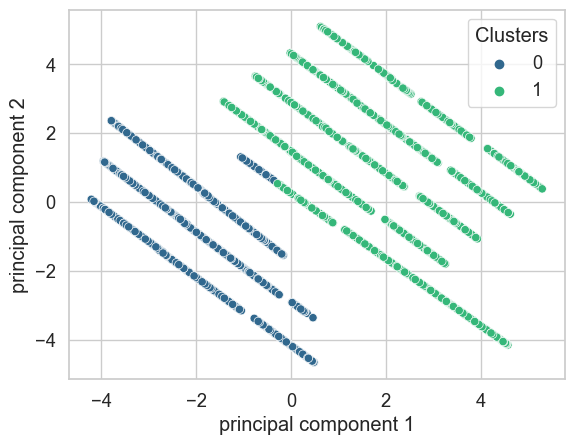

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_trans)
pca_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

#silhoutte method to obtain optimal no. of clusters for our dataset, higher value indicates optimal cluster
import sklearn.cluster as cluster
import sklearn.metrics as metrics
for i in range(2,10):
    labels=cluster.KMeans(n_clusters=i,random_state=200).fit(pca_df).labels_
    #print ("Silhouette score for k(clusters) = "+str(i)+" is "
    #       +str(metrics.silhouette_score(pca_df,labels,metric="euclidean",sample_size=1000,random_state=200)))

kmeans = cluster.KMeans(n_clusters=2)
kmeans = kmeans.fit(pca_df)    

#plotting the clusters
pca_df['Clusters'] = kmeans.labels_
sns.scatterplot(x="principal component 1", y="principal component 2",hue = 'Clusters',  data=pca_df,palette='viridis')

In [21]:
# Random Forest 모델

# train 데이터와 타겟 변수 분리
X = train_trans[['air_inflow', 'air_end_temp', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe']]
y = train_trans['type']

# train/test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 학습
rf_model.fit(X_train, y_train)

# 모델 평가
print('Accuracy:', rf_model.score(X_test, y_test))

Accuracy: 0.5469387755102041


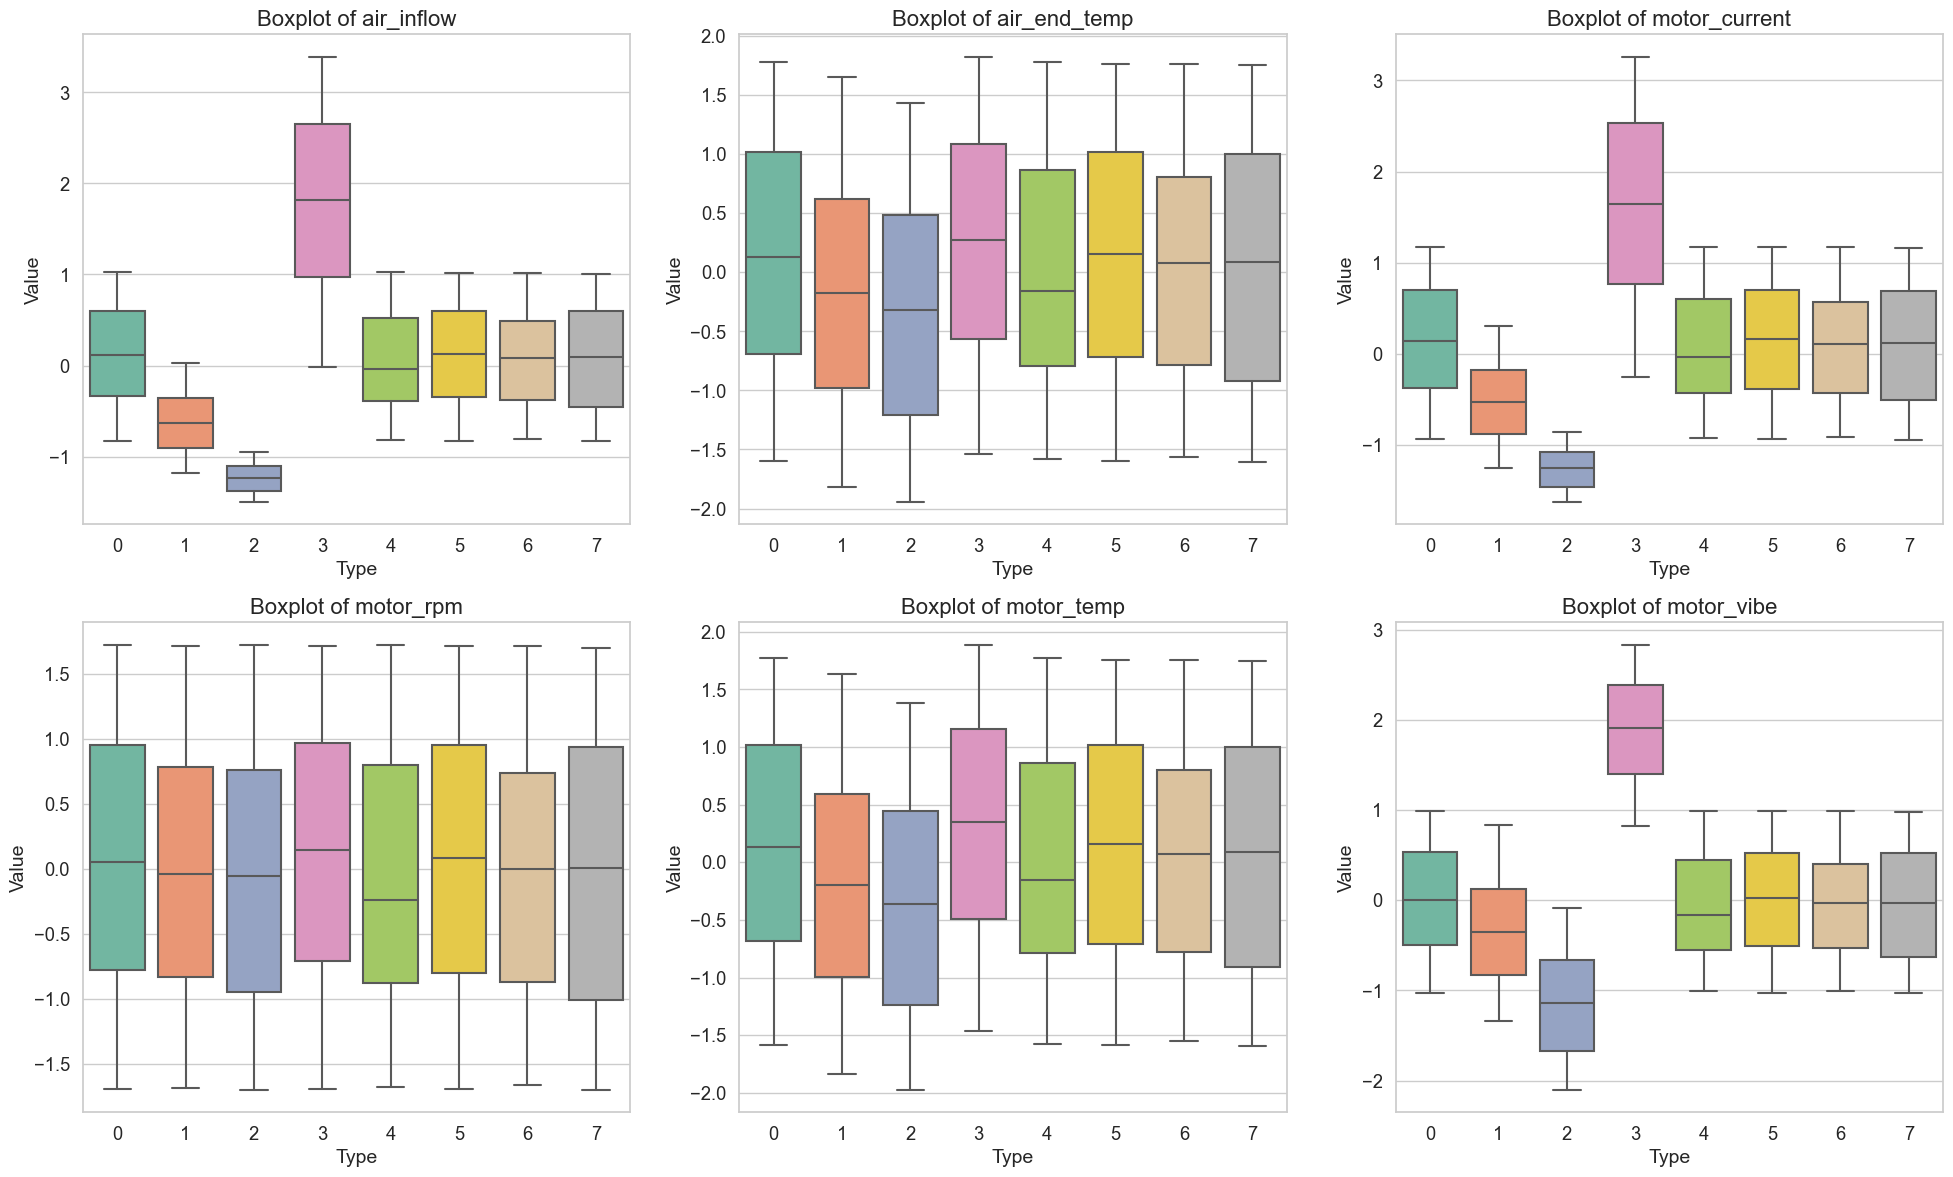

In [10]:
# 박스 플롯

train_trans.columns = ['air_inflow',
              'air_end_temp',
              'motor_current',
              'motor_rpm',
              'motor_temp',
              'motor_vibe',
              'type']

sns.set(style='whitegrid', font_scale=1.2)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24,14))

for i, col in enumerate(train_trans.columns[:-1]):
    row = i // 3
    col_num = i % 3
    ax = axs[row][col_num]
    sns.boxplot(x='type', y=col, data=train_trans, ax=ax, palette='Set2')
    ax.set_title(f'Boxplot of {col}', fontsize=16)
    ax.set_xlabel('Type', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)

plt.show()

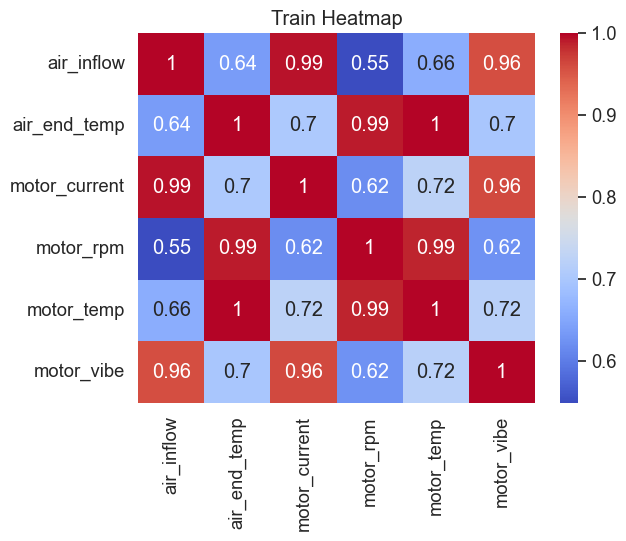

In [11]:
# 히트맵

sns.heatmap(train_trans[['air_inflow',
                         'air_end_temp',
                        'motor_current',
                          'motor_rpm',
                            'motor_temp',
                              'motor_vibe']].corr(), cmap='coolwarm', annot=True).set_title("Train Heatmap")
plt.show()

In [12]:
# 타입별로 데이터프레임만들기
train_type_0, train_type_1, train_type_2, train_type_3, train_type_4, train_type_5, train_type_6, train_type_7 = [train_trans.groupby('type').get_group(i) for i in range(8)]

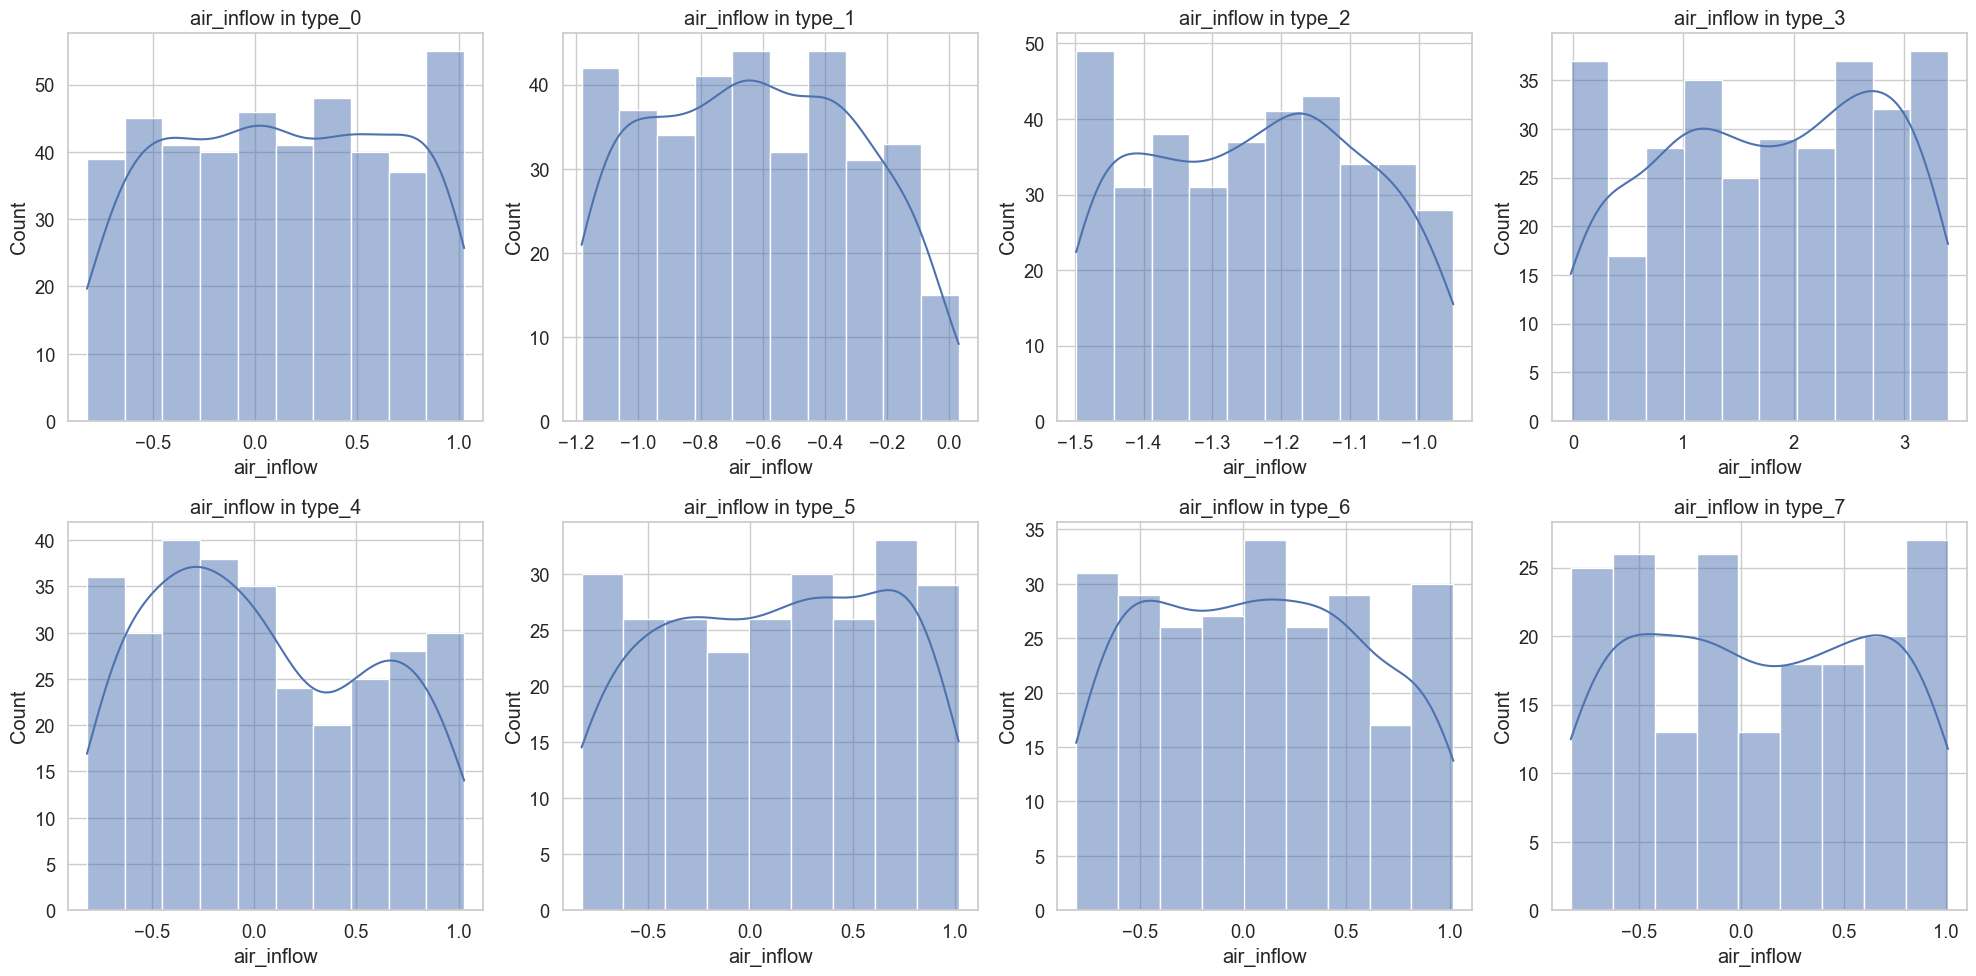

In [13]:
# 타입별로 히스토그램 시각화
# Air_inflow

fig, ax = plt.subplots(2, 4, figsize=(20,10))

for i, axi in enumerate(ax.flat):
    sns.histplot(x='air_inflow',
                 data=train_trans[train_trans['type'] == i],
                 ax=axi,
                 kde=True).set_title(f"air_inflow in type_{i}")
    
plt.tight_layout()
plt.show()

<Axes: xlabel='air_end_temp', ylabel='Count'>

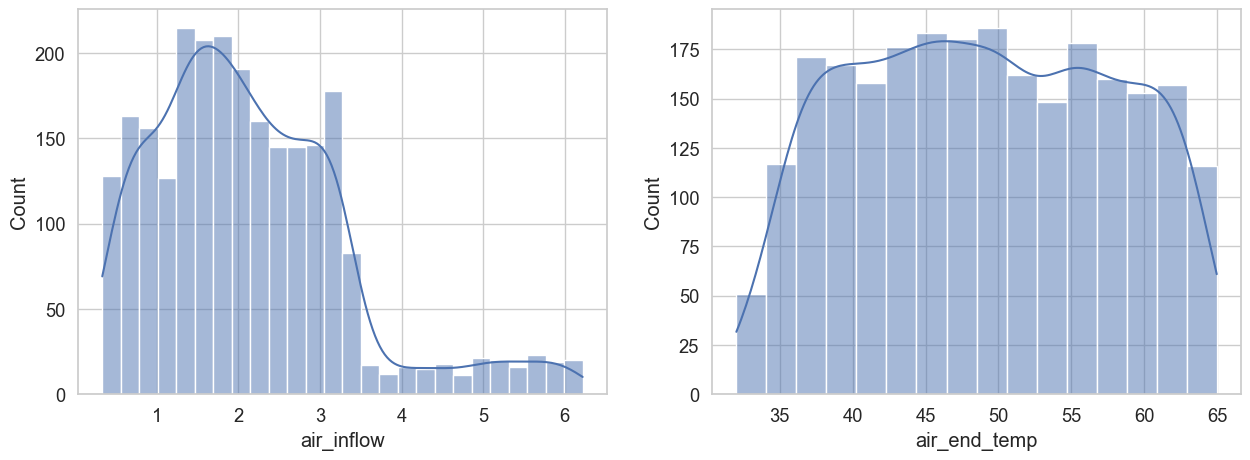

In [14]:
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(x='air_inflow',data=train,ax=ax[0],kde=True,legend=train["air_inflow"])
sns.histplot(x='air_end_temp',data=train,ax=ax[1],kde=True,legend=train["air_end_temp"])


<Axes: xlabel='motor_rpm', ylabel='Count'>

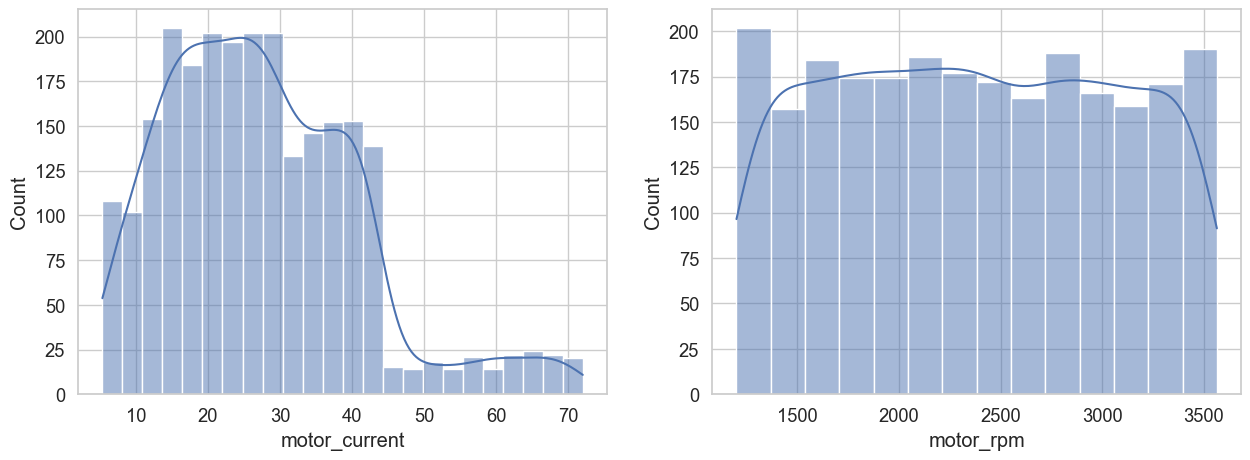

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(x='motor_current',data=train,ax=ax[0],kde=True,legend=train["motor_current"])
sns.histplot(x='motor_rpm',data=train,ax=ax[1],kde=True,legend=train["motor_rpm"])

<Axes: xlabel='motor_vibe', ylabel='Count'>

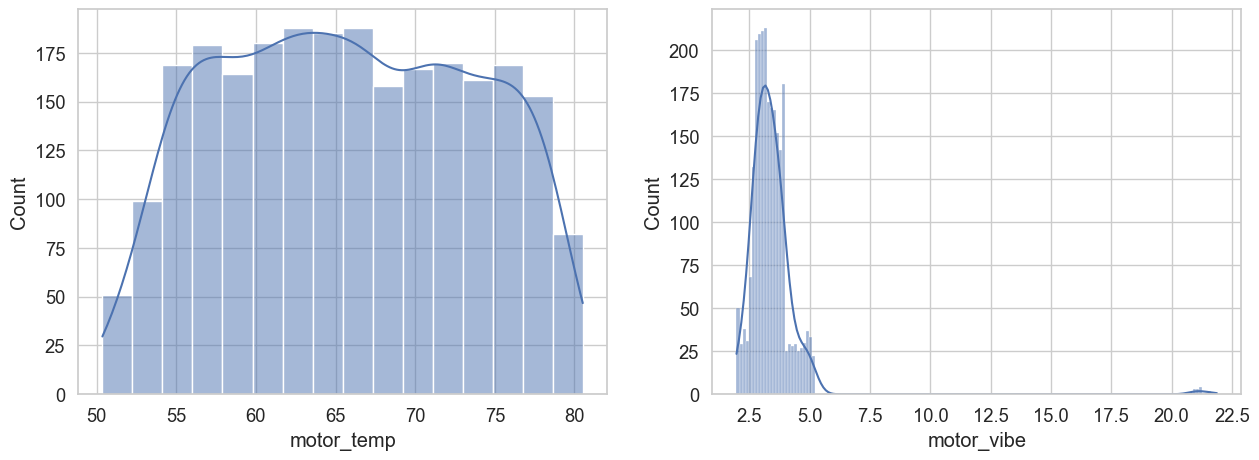

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(x='motor_temp',data=train,ax=ax[0],kde=True,legend=train["motor_temp"])
sns.histplot(x='motor_vibe',data=train,ax=ax[1],kde=True,legend=train["motor_vibe"])

In [17]:
# 예시 Model

# feature와 target 지정
X = train.drop(["type"], axis=1)
y = train["type"]

# 학습 데이터와 검증 데이터로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 검증 데이터로 정확도 측정
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5699797160243407


In [18]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

# feature와 target 지정
X = train.drop(["type"], axis=1)
y = train["type"]

# 학습 데이터와 검증 데이터로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)

[[21  0  0  0 18 11 14 16]
 [ 0 78  0  0  0  0  0  0]
 [ 0  0 75  0  0  0  0  0]
 [ 0  0  0 68  0  0  0  0]
 [15  0  0  0 15 11  6 16]
 [15  0  0  0 14  6  3 13]
 [13  0  0  0  9 10 11  5]
 [ 7  0  0  0  7  2  7  7]]


In [19]:
# Classification Report
from sklearn.metrics import classification_report

# feature와 target 지정
X = train.drop(["type"], axis=1)
y = train["type"]

# 학습 데이터와 검증 데이터로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = model.predict(X_val)
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.30      0.26      0.28        80
           1       1.00      1.00      1.00        78
           2       1.00      1.00      1.00        75
           3       1.00      1.00      1.00        68
           4       0.24      0.24      0.24        63
           5       0.15      0.12      0.13        51
           6       0.27      0.23      0.25        48
           7       0.12      0.23      0.16        30

    accuracy                           0.57       493
   macro avg       0.51      0.51      0.51       493
weighted avg       0.58      0.57      0.57       493



In [20]:
# Kfold 교차 검증
# feature와 target 지정
X = train.drop(["type"], axis=1)
y = train["type"]

# 교차 검증 객체 생성
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 객체 생성
model = RandomForestClassifier()

# 교차 검증 수행
scores = cross_val_score(model, X, y, cv=kfold)

# 교차 검증 결과 출력
print("교차 검증 점수: ", scores)
print("평균 교차 검증 점수: ", scores.mean())

교차 검증 점수:  [0.55983773 0.52941176 0.55578093 0.54674797 0.57723577]
평균 교차 검증 점수:  0.5538028331601774
